# Machine Learning Engineer Nanodegree
## Reinforcement Learning
## Project: Train a Smartcab to Drive

Welcome to the fourth project of the Machine Learning Engineer Nanodegree! In this notebook, template code has already been provided for you to aid in your analysis of the *Smartcab* and your implemented learning algorithm. You will not need to modify the included code beyond what is requested. There will be questions that you must answer which relate to the project and the visualizations provided in the notebook. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide in `agent.py`.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

-----

## Getting Started
In this project, you will work towards constructing an optimized Q-Learning driving agent that will navigate a *Smartcab* through its environment towards a goal. Since the *Smartcab* is expected to drive passengers from one location to another, the driving agent will be evaluated on two very important metrics: **Safety** and **Reliability**. A driving agent that gets the *Smartcab* to its destination while running red lights or narrowly avoiding accidents would be considered **unsafe**. Similarly, a driving agent that frequently fails to reach the destination in time would be considered **unreliable**. Maximizing the driving agent's **safety** and **reliability** would ensure that *Smartcabs* have a permanent place in the transportation industry.

**Safety** and **Reliability** are measured using a letter-grade system as follows:

| Grade 	| Safety 	| Reliability 	|
|:-----:	|:------:	|:-----------:	|
|   A+  	|  Agent commits no traffic violations,<br/>and always chooses the correct action. | Agent reaches the destination in time<br />for 100% of trips. |
|   A   	|  Agent commits few minor traffic violations,<br/>such as failing to move on a green light. | Agent reaches the destination on time<br />for at least 90% of trips. |
|   B   	| Agent commits frequent minor traffic violations,<br/>such as failing to move on a green light. | Agent reaches the destination on time<br />for at least 80% of trips. |
|   C   	|  Agent commits at least one major traffic violation,<br/> such as driving through a red light. | Agent reaches the destination on time<br />for at least 70% of trips. |
|   D   	| Agent causes at least one minor accident,<br/> such as turning left on green with oncoming traffic.       	| Agent reaches the destination on time<br />for at least 60% of trips. |
|   F   	|  Agent causes at least one major accident,<br />such as driving through a red light with cross-traffic.      	| Agent fails to reach the destination on time<br />for at least 60% of trips. |

To assist evaluating these important metrics, you will need to load visualization code that will be used later on in the project. Run the code cell below to import this code which is required for your analysis.

In [1]:
# Import the visualization code
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

### Understand the World
Before starting to work on implementing your driving agent, it's necessary to first understand the world (environment) which the *Smartcab* and driving agent work in. One of the major components to building a self-learning agent is understanding the characteristics about the agent, which includes how the agent operates. To begin, simply run the `agent.py` agent code exactly how it is -- no need to make any additions whatsoever. Let the resulting simulation run for some time to see the various working components. Note that in the visual simulation (if enabled), the **white vehicle** is the *Smartcab*.

### Question 1
In a few sentences, describe what you observe during the simulation when running the default `agent.py` agent code. Some things you could consider:
- *Does the Smartcab move at all during the simulation?*
- *What kind of rewards is the driving agent receiving?*
- *How does the light changing color affect the rewards?*  

**Hint:** From the `/smartcab/` top-level directory (where this notebook is located), run the command 
```bash
'python smartcab/agent.py'
```

**Answer:**

By default, the Smartcab takes no action and simply idles at the intersection.

Even though the agent is not responding, it is still receiving rewards and penalties based on its compliance (or lack thereof) of traffic regulations. These are relatively small rewards or penalties for moving or not moving when required to do so.

The rewards it receives are strongly correlated with the state of the traffic light. At a red light, the Smartcab is rewarded for lawfully stopping at the intersection. When the light turns green, the rewards are more interesting. If, by chance, the intersection is blocked by another car, the Smartcab will receive a positive reward for yielding to oncoming traffic. However, if the road ahead is clear, the S|martcab is penalized for for not moving forward.

### Understand the Code
In addition to understanding the world, it is also necessary to understand the code itself that governs how the world, simulation, and so on operate. Attempting to create a driving agent would be difficult without having at least explored the *"hidden"* devices that make everything work. In the `/smartcab/` top-level directory, there are two folders: `/logs/` (which will be used later) and `/smartcab/`. Open the `/smartcab/` folder and explore each Python file included, then answer the following question.

### Question 2
- *In the *`agent.py`* Python file, choose three flags that can be set and explain how they change the simulation.*
- *In the *`environment.py`* Python file, what Environment class function is called when an agent performs an action?*
- *In the *`simulator.py`* Python file, what is the difference between the *`'render_text()'`* function and the *`'render()'`* function?*
- *In the *`planner.py`* Python file, will the *`'next_waypoint()`* function consider the North-South or East-West direction first?*

**Answer:**

The ```agent.py``` module is responsible for controlling the agent driving the Smartcab. There are several flags that can be set to modify the behavior of the Smartcab. Three important flags are:

* ```enforce_deadline```: This flag will decide whether the Smartcab will be required to reach its destination within the specified target deadline. If the flag is set, the Smartcab is required to reach its destination within the time limit or the simulation will end in failure. If the flag is off, however, the Smartcab is allowed to continue operating for additional time. However even when deadlines are not enforced, there is a hard  deadline of -100, at which point the trial will end. When the deadline is enforced, the reward will be adjusted by a penalty depending on how much time is remaining.
* ```n_test```: This flag determines the number of testing trial the simulator will run after the Smartcab has completed its training.
* ```learning```: This flag will determine whether the Smartcab will attempt attempt to learn from it's environment. If the flag is not set, the Smartcab will be limited to taking random actions. If the flag is set, however, the Smartcab will operate under an epsilon-greedy strategy. The learning Smartcab will try to exploit what it has learned by selecting actions with the maximum Q-value score. However, with epsilon probability it will attempt to explore more of the state space by choosing actions at random.

In ```enironment.py```, the ```act()``` method of the ```Environment``` class is called when an an agent performs an action. The function performs the requested action and calculates the reward for for taking (or failing to take) the action.

In ```simulator.py```, the ```render_text()``` prints simulated trial data to the console, while ```render()``` updates the GUI display.

In ```planner.py```, the ```next_waypoint()``` function will first consider the East-West direction before evaluating North-South.

-----
## Implement a Basic Driving Agent

The first step to creating an optimized Q-Learning driving agent is getting the agent to actually take valid actions. In this case, a valid action is one of `None`, (do nothing) `'Left'` (turn left), `'Right'` (turn right), or `'Forward'` (go forward). For your first implementation, navigate to the `'choose_action()'` agent function and make the driving agent randomly choose one of these actions. Note that you have access to several class variables that will help you write this functionality, such as `'self.learning'` and `'self.valid_actions'`. Once implemented, run the agent file and simulation briefly to confirm that your driving agent is taking a random action each time step.

### Basic Agent Simulation Results
To obtain results from the initial simulation, you will need to adjust following flags:
- `'enforce_deadline'` - Set this to `True` to force the driving agent to capture whether it reaches the destination in time.
- `'update_delay'` - Set this to a small value (such as `0.01`) to reduce the time between steps in each trial.
- `'log_metrics'` - Set this to `True` to log the simluation results as a `.csv` file in `/logs/`.
- `'n_test'` - Set this to `'10'` to perform 10 testing trials.

Optionally, you may disable to the visual simulation (which can make the trials go faster) by setting the `'display'` flag to `False`. Flags that have been set here should be returned to their default setting when debugging. It is important that you understand what each flag does and how it affects the simulation!

Once you have successfully completed the initial simulation (there should have been 20 training trials and 10 testing trials), run the code cell below to visualize the results. Note that log files are overwritten when identical simulations are run, so be careful with what log file is being loaded!


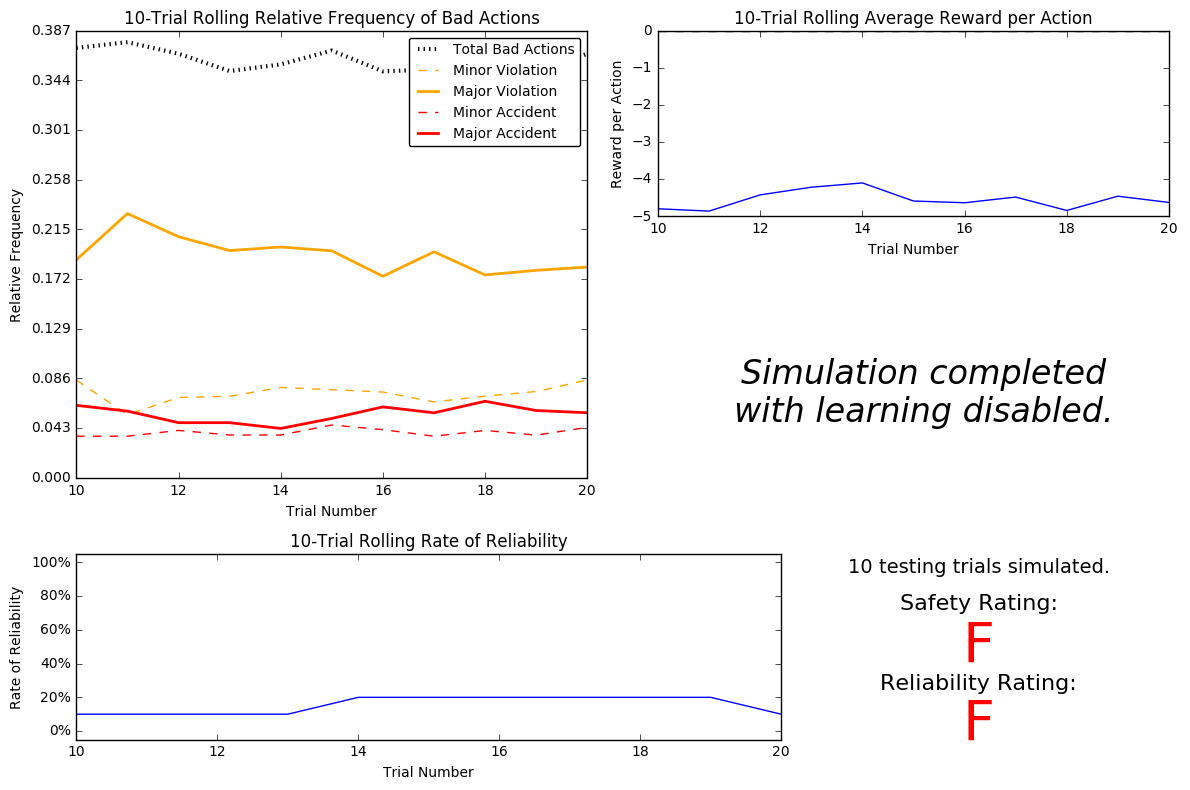

In [2]:
# Load the 'sim_no-learning' log file from the initial simulation results
vs.plot_trials('sim_no-learning.csv')

### Question 3
Using the visualization above that was produced from your initial simulation, provide an analysis and make several observations about the driving agent. Be sure that you are making at least one observation about each panel present in the visualization. Some things you could consider:
- *How frequently is the driving agent making bad decisions? How many of those bad decisions cause accidents?*
- *Given that the agent is driving randomly, does the rate of reliabilty make sense?*
- *What kind of rewards is the agent receiving for its actions? Do the rewards suggest it has been penalized heavily?*
- *As the number of trials increases, does the outcome of results change significantly?*
- *Would this Smartcab be considered safe and/or reliable for its passengers? Why or why not?*

**Answer:**

Making random decisions is not a good strategy for the Smartcab!

The agent makes bad decisions approximately 35% of the time. In fact, more than 4% of the time it's decisions lead to major accidents, and around 6% of the time its decisions lead to minor accidents.

Given that the agent was making random decisions, it's actually surprising that it was able to reach it's destination twice over the course of the trials. It makes sense that most of the time the random actions would not lead to successful completion.

The agent is still subject to the same rewards and penalties as it was when it didn't move, however, now that it is capable of actually driving, it is subject to even more rewards and penalties. Additional rewards involve following waypoints or reaching it's destination. It is also subject to more severe penalties for traffic violations or risky maneuvers likely to result in minor or major accidents. The agent has been heavily penalized the significant number of accidents caused when taking random actions.

Increasing the number of trials didn't seem to noticeably change the outcome of results. Random actions more or less acheived the same number of good and bad results from trial to trial.

This Smartcab should be considered neither safe nor reliable. In fact, it is an outright menace to society likely to cause numerous accidents if it were allowed to drive with the current random policy. It's ratings reflect this, earning an "F" score in both categories.

-----
## Inform the Driving Agent
The second step to creating an optimized Q-learning driving agent is defining a set of states that the agent can occupy in the environment. Depending on the input, sensory data, and additional variables available to the driving agent, a set of states can be defined for the agent so that it can eventually *learn* what action it should take when occupying a state. The condition of `'if state then action'` for each state is called a **policy**, and is ultimately what the driving agent is expected to learn. Without defining states, the driving agent would never understand which action is most optimal -- or even what environmental variables and conditions it cares about!

### Identify States
Inspecting the `'build_state()'` agent function shows that the driving agent is given the following data from the environment:
- `'waypoint'`, which is the direction the *Smartcab* should drive leading to the destination, relative to the *Smartcab*'s heading.
- `'inputs'`, which is the sensor data from the *Smartcab*. It includes 
  - `'light'`, the color of the light.
  - `'left'`, the intended direction of travel for a vehicle to the *Smartcab*'s left. Returns `None` if no vehicle is present.
  - `'right'`, the intended direction of travel for a vehicle to the *Smartcab*'s right. Returns `None` if no vehicle is present.
  - `'oncoming'`, the intended direction of travel for a vehicle across the intersection from the *Smartcab*. Returns `None` if no vehicle is present.
- `'deadline'`, which is the number of actions remaining for the *Smartcab* to reach the destination before running out of time.

### Question 4
*Which features available to the agent are most relevant for learning both **safety** and **efficiency**? Why are these features appropriate for modeling the *Smartcab* in the environment? If you did not choose some features, why are those features* not *appropriate?*

**Answer:**

Waypoint is critical to the Smartcab's efficiency. Without knowing where to go, it's unlikely to reach it's destination in a timely manner. Following the quickest route as designated by the waypoint, however, isn't strictly necessary for safety. However, we should include the waypoint in our model of Smartcab's environment.

The color of the light is critical for the safety of the drive. While the Smartcab may gain some efficiency by running a red light if the other sensors show no oncoming cars, this is extremely reckless (and illegal) behavior that should be avoided.

The oncoming sensor is also important for safety. Without taking into account the intent of cars on the opposite side of the road, it is extremely likely that the Smartcab may be involved in a crash when it either attempts to move forward when the opposite car is trying to turn left or attempting to turn left when the opposite car is trying to move forward.

Perhaps surprisingly for humans trained to drive defensively, the left and right sensors will not add significant value to either the safety or efficiency of the Smartcab if the agent and other calls all follow traffic rules. While the Smartcab is idling at a red light, the cars to the left and right can safely turn or move forward. Conversely, while the Smartcab advances with a green light, cars to the left and right will be safely stopped at  red light. If we were to allow the Smartcab to run a red light to get to a destination more quickly, however, the left and right sensors would be necessary to avoid a crash.

It should be noted that by not including the left sensor, it will no longer be safe to turn right on red. We will consider this an advanced maneuver and be willing to live without this efficiency. In exchange, the state space will be significantly reduced because we will no longer have to consider cars to the left of the Smartcab. Unfortunately, turning right on a red light is a legal action and the Smartcab will likely attempt to try this during training. It's likely that the agent will eventually learn that it cannot safely turn right on red but this isn't guaranteed. To be completely safe, we would need to include the left sensor and be forced to deal with the additional states that come along with it.

Deadline seems unimportant for either safety or efficiency. While this is an important metric to score the effectiveness of the agent's policy, knowing the deadline doesn't make it any safer or more efficient to travel. While a dishonest agent could use the deadline to knowlingly take a less efficient route to charge more for the ride, we should safely be able to ignore the deadline to model the environment.

### Define a State Space
When defining a set of states that the agent can occupy, it is necessary to consider the *size* of the state space. That is to say, if you expect the driving agent to learn a **policy** for each state, you would need to have an optimal action for *every* state the agent can occupy. If the number of all possible states is very large, it might be the case that the driving agent never learns what to do in some states, which can lead to uninformed decisions. For example, consider a case where the following features are used to define the state of the *Smartcab*:

`('is_raining', 'is_foggy', 'is_red_light', 'turn_left', 'no_traffic', 'previous_turn_left', 'time_of_day')`.

How frequently would the agent occupy a state like `(False, True, True, True, False, False, '3AM')`? Without a near-infinite amount of time for training, it's doubtful the agent would ever learn the proper action!

### Question 5
*If a state is defined using the features you've selected from **Question 4**, what would be the size of the state space? Given what you know about the evironment and how it is simulated, do you think the driving agent could learn a policy for each possible state within a reasonable number of training trials?*  
**Hint:** Consider the *combinations* of features to calculate the total number of states!

**Answer:**

We have identified the following important states to include in the model:

* waypoint: right, left, forward
* light: red, green
* oncoming: none, forward, left right

The total size of the state space would then be the combination of all possible states for the individual inputs: ```3 * 2 * 4 = 24```.

This is a relatively small sample space that should be easy to learn through a reasonably number of training trials. To fully train the agent, we would need to try each of the four valid actions at each state. This would require a minimum of ```24 * 4 = 96``` steps. Of course, the actual number of steps required to train the agent will be much higher as the Smartcab will likely find itself revisiting previously explored states many times.

If we are willing to apply some domain knowledge to the planning process, it would be possible to further reduce the state space. For example, if we code an absolute rule that the Smartcab will always stop at a red light, then we can reduce the state space by half and only have to learn what actions to take when the light is green. For the purposes of this project, however, we will try to learn all of the states through reinforcement learning.

### Update the Driving Agent State
For your second implementation, navigate to the `'build_state()'` agent function. With the justification you've provided in **Question 4**, you will now set the `'state'` variable to a tuple of all the features necessary for Q-Learning. Confirm your driving agent is updating its state by running the agent file and simulation briefly and note whether the state is displaying. If the visual simulation is used, confirm that the updated state corresponds with what is seen in the simulation.

**Note:** Remember to reset simulation flags to their default setting when making this observation!

-----
## Implement a Q-Learning Driving Agent
The third step to creating an optimized Q-Learning agent is to begin implementing the functionality of Q-Learning itself. The concept of Q-Learning is fairly straightforward: For every state the agent visits, create an entry in the Q-table for all state-action pairs available. Then, when the agent encounters a state and performs an action, update the Q-value associated with that state-action pair based on the reward received and the interative update rule implemented. Of course, additional benefits come from Q-Learning, such that we can have the agent choose the *best* action for each state based on the Q-values of each state-action pair possible. For this project, you will be implementing a *decaying,* $\epsilon$*-greedy* Q-learning algorithm with *no* discount factor. Follow the implementation instructions under each **TODO** in the agent functions.

Note that the agent attribute `self.Q` is a dictionary: This is how the Q-table will be formed. Each state will be a key of the `self.Q` dictionary, and each value will then be another dictionary that holds the *action* and *Q-value*. Here is an example:

```
{ 'state-1': { 
    'action-1' : Qvalue-1,
    'action-2' : Qvalue-2,
     ...
   },
  'state-2': {
    'action-1' : Qvalue-1,
     ...
   },
   ...
}
```

Furthermore, note that you are expected to use a *decaying* $\epsilon$ *(exploration) factor*. Hence, as the number of trials increases, $\epsilon$ should decrease towards 0. This is because the agent is expected to learn from its behavior and begin acting on its learned behavior. Additionally, The agent will be tested on what it has learned after $\epsilon$ has passed a certain threshold (the default threshold is 0.01). For the initial Q-Learning implementation, you will be implementing a linear decaying function for $\epsilon$.

### Q-Learning Simulation Results
To obtain results from the initial Q-Learning implementation, you will need to adjust the following flags and setup:
- `'enforce_deadline'` - Set this to `True` to force the driving agent to capture whether it reaches the destination in time.
- `'update_delay'` - Set this to a small value (such as `0.01`) to reduce the time between steps in each trial.
- `'log_metrics'` - Set this to `True` to log the simluation results as a `.csv` file and the Q-table as a `.txt` file in `/logs/`.
- `'n_test'` - Set this to `'10'` to perform 10 testing trials.
- `'learning'` - Set this to `'True'` to tell the driving agent to use your Q-Learning implementation.

In addition, use the following decay function for $\epsilon$:

$$ \epsilon_{t+1} = \epsilon_{t} - 0.05, \hspace{10px}\textrm{for trial number } t$$

If you have difficulty getting your implementation to work, try setting the `'verbose'` flag to `True` to help debug. Flags that have been set here should be returned to their default setting when debugging. It is important that you understand what each flag does and how it affects the simulation! 

Once you have successfully completed the initial Q-Learning simulation, run the code cell below to visualize the results. Note that log files are overwritten when identical simulations are run, so be careful with what log file is being loaded!

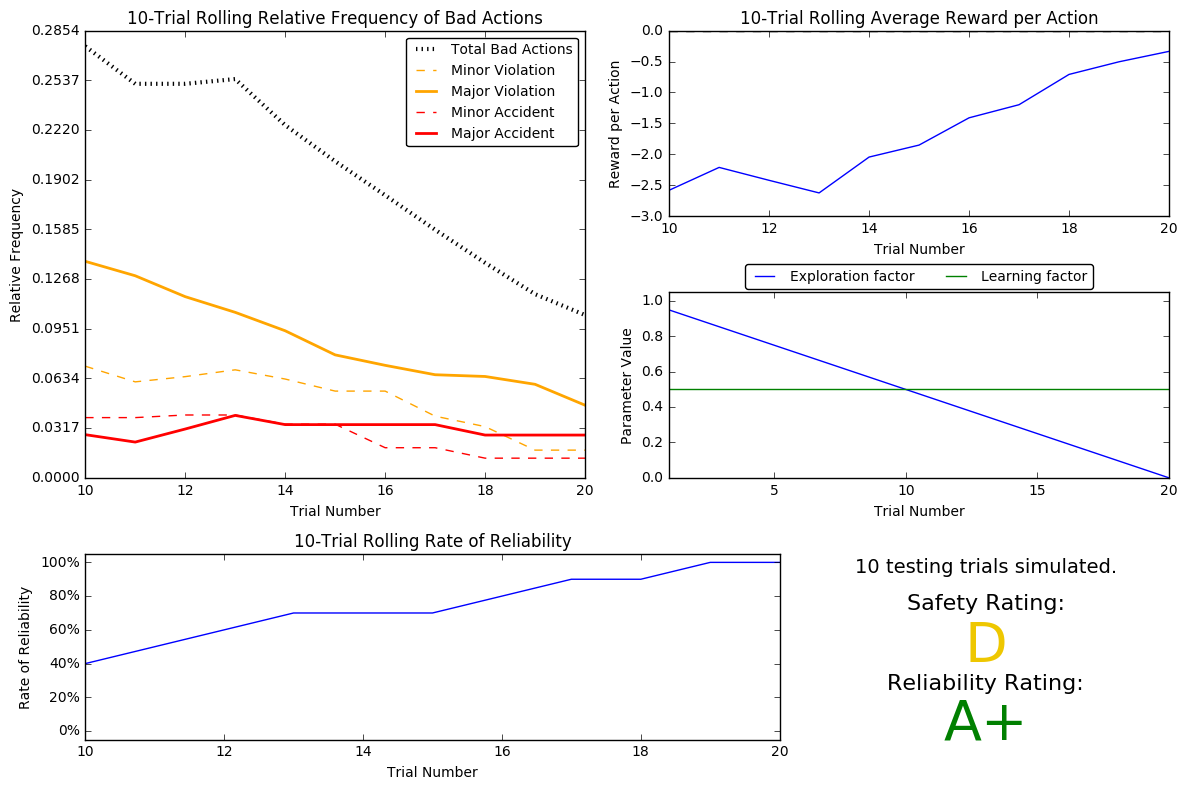

In [3]:
# Load the 'sim_default-learning' file from the default Q-Learning simulation
vs.plot_trials('sim_default-learning.csv')

### Question 6
Using the visualization above that was produced from your default Q-Learning simulation, provide an analysis and make observations about the driving agent like in **Question 3**. Note that the simulation should have also produced the Q-table in a text file which can help you make observations about the agent's learning. Some additional things you could consider:  
- *Are there any observations that are similar between the basic driving agent and the default Q-Learning agent?*
- *Approximately how many training trials did the driving agent require before testing? Does that number make sense given the epsilon-tolerance?*
- *Is the decaying function you implemented for $\epsilon$ (the exploration factor) accurately represented in the parameters panel?*
- *As the number of training trials increased, did the number of bad actions decrease? Did the average reward increase?*
- *How does the safety and reliability rating compare to the initial driving agent?*

**Answer:**

After the Q-learning was implemented, the Smartcab's performance has increased dramatically. While this analysis will focus on the trial visualized above, it should be noted that the Smartcab performance was still subject to wide swings in the results. Sometimes safety was higher than reliability and sometimes it was the other way around.

There were 20 training trials before the testing started. This is right in line with expectation as the epsilon decayed linearly from 1.0 to 0 (below the tolerance value of 0.01) over the course of the 20 runs.

The decaying function is accurated represented in the parameters panel. The linear decay is shown as a line steadily decreasing in value as the training progresses.

As the training trials increased, the number of bad actions began to decrease to around 10% while the average reward value continued to increase.

In this particular trial, there were still enough bad actions to confer a poor safety rating. However the nummber of bad actions is clearly on the decline. On the other hand, the reliability score steadily increased to a near perfect level.

The Q-learning is obviously working. The Smartcab just needs to learn more.

-----
## Improve the Q-Learning Driving Agent
The third step to creating an optimized Q-Learning agent is to perform the optimization! Now that the Q-Learning algorithm is implemented and the driving agent is successfully learning, it's necessary to tune settings and adjust learning paramaters so the driving agent learns both **safety** and **efficiency**. Typically this step will require a lot of trial and error, as some settings will invariably make the learning worse. One thing to keep in mind is the act of learning itself and the time that this takes: In theory, we could allow the agent to learn for an incredibly long amount of time; however, another goal of Q-Learning is to *transition from experimenting with unlearned behavior to acting on learned behavior*. For example, always allowing the agent to perform a random action during training (if $\epsilon = 1$ and never decays) will certainly make it *learn*, but never let it *act*. When improving on your Q-Learning implementation, consider the impliciations it creates and whether it is logistically sensible to make a particular adjustment.

### Improved Q-Learning Simulation Results
To obtain results from the initial Q-Learning implementation, you will need to adjust the following flags and setup:
- `'enforce_deadline'` - Set this to `True` to force the driving agent to capture whether it reaches the destination in time.
- `'update_delay'` - Set this to a small value (such as `0.01`) to reduce the time between steps in each trial.
- `'log_metrics'` - Set this to `True` to log the simluation results as a `.csv` file and the Q-table as a `.txt` file in `/logs/`.
- `'learning'` - Set this to `'True'` to tell the driving agent to use your Q-Learning implementation.
- `'optimized'` - Set this to `'True'` to tell the driving agent you are performing an optimized version of the Q-Learning implementation.

Additional flags that can be adjusted as part of optimizing the Q-Learning agent:
- `'n_test'` - Set this to some positive number (previously 10) to perform that many testing trials.
- `'alpha'` - Set this to a real number between 0 - 1 to adjust the learning rate of the Q-Learning algorithm.
- `'epsilon'` - Set this to a real number between 0 - 1 to adjust the starting exploration factor of the Q-Learning algorithm.
- `'tolerance'` - set this to some small value larger than 0 (default was 0.05) to set the epsilon threshold for testing.

Furthermore, use a decaying function of your choice for $\epsilon$ (the exploration factor). Note that whichever function you use, it **must decay to **`'tolerance'`** at a reasonable rate**. The Q-Learning agent will not begin testing until this occurs. Some example decaying functions (for $t$, the number of trials):

$$ \epsilon = a^t, \textrm{for } 0 < a < 1 \hspace{50px}\epsilon = \frac{1}{t^2}\hspace{50px}\epsilon = e^{-at}, \textrm{for } 0 < a < 1 \hspace{50px} \epsilon = \cos(at), \textrm{for } 0 < a < 1$$
You may also use a decaying function for $\alpha$ (the learning rate) if you so choose, however this is typically less common. If you do so, be sure that it adheres to the inequality $0 \leq \alpha \leq 1$.

If you have difficulty getting your implementation to work, try setting the `'verbose'` flag to `True` to help debug. Flags that have been set here should be returned to their default setting when debugging. It is important that you understand what each flag does and how it affects the simulation! 

Once you have successfully completed the improved Q-Learning simulation, run the code cell below to visualize the results. Note that log files are overwritten when identical simulations are run, so be careful with what log file is being loaded!

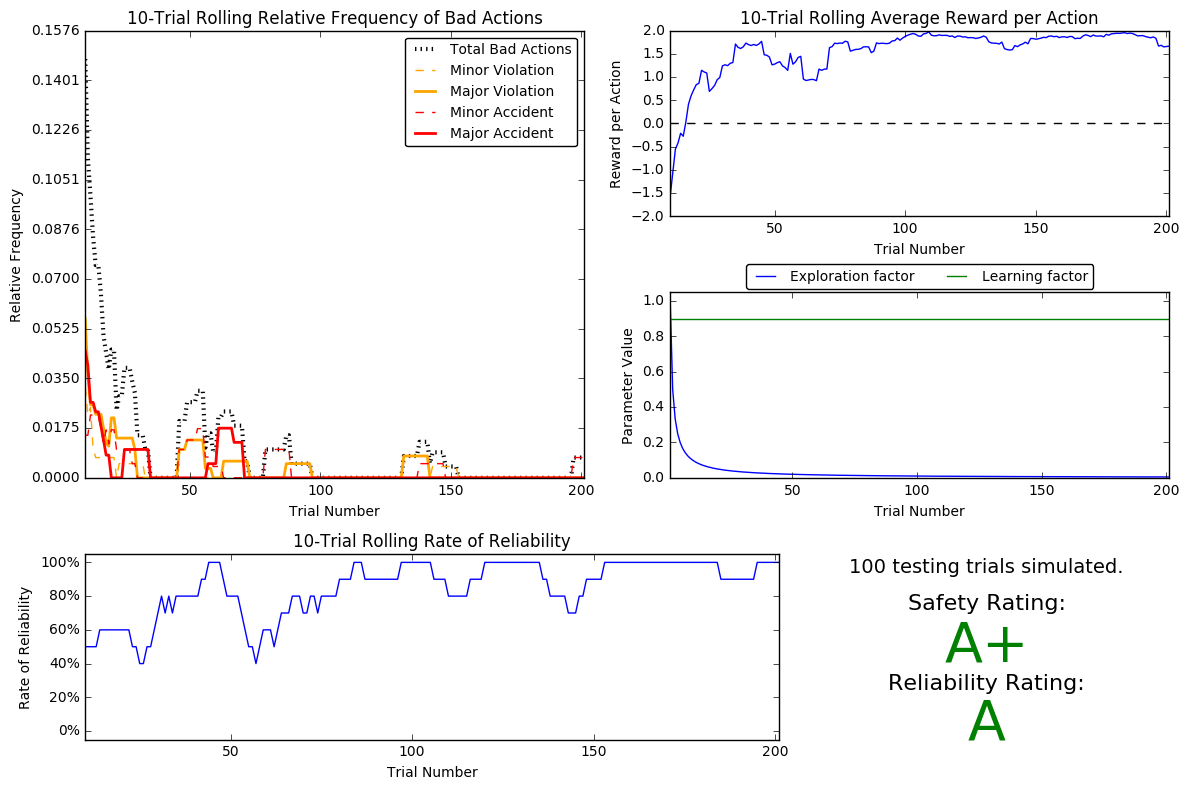

In [4]:
# Load the 'sim_improved-learning' file from the improved Q-Learning simulation
vs.plot_trials('sim_improved-learning.csv')

### Question 7
Using the visualization above that was produced from your improved Q-Learning simulation, provide a final analysis and make observations about the improved driving agent like in **Question 6**. Questions you should answer:  
- *What decaying function was used for epsilon (the exploration factor)?*
- *Approximately how many training trials were needed for your agent before begining testing?*
- *What epsilon-tolerance and alpha (learning rate) did you use? Why did you use them?*
- *How much improvement was made with this Q-Learner when compared to the default Q-Learner from the previous section?*
- *Would you say that the Q-Learner results show that your driving agent successfully learned an appropriate policy?*
- *Are you satisfied with the safety and reliability ratings of the *Smartcab*?*

**Answer:**

The decaying function for exploration was chosen to be ```epsilon = 1 / t``` for step t. From the initial Q-learning simulation we saw that bad actions declined linearly with the linear exploration function. That same pattern was observed even with a longer training period. Therefore we chose a function that balanced giving enough time for exploration with one that gave faster than linear decay.

The number of training trials was extended to 200 to give the Smartcab enough time to experience and react to as many states from across the state space as possible. The number of testing trials was increased to 100 to ensure that the agent was actually able to learn and did not merely get a few lucky runs.

The epsilon tolerance was picked to be 0.005. This number was chosen to cap the training trials to the desired 200 trials. Because the agent learned using only immediate rewards, the choice of the learning rate alpha was relatively arbitrary. A value of 0.9 was chosen to more heavily weight the most recent experience while still preserving some prior learning.

This Q-learner results showed significant improvement over the previous Q-learner. In fact, the Smartcab was able to consistently achieve an "A+" score for safety. The reliability score of "A" reflect the fact that the Smartcab was able to deliver most passengers to their destinations on time. Some further research is necessary to determine whether missing the perfect score was the result of insufficient learning or if this was out of the control of the agent because it's journey was stalled by other cars on the road.

This was a very satisfying improvement for both safety and reliability. This was reflected not only in its new ratings, but also in the consistently high rewards it received for each action.

### Define an Optimal Policy

Sometimes, the answer to the important question *"what am I trying to get my agent to learn?"* only has a theoretical answer and cannot be concretely described. Here, however, you can concretely define what it is the agent is trying to learn, and that is the U.S. right-of-way traffic laws. Since these laws are known information, you can further define, for each state the *Smartcab* is occupying, the optimal action for the driving agent based on these laws. In that case, we call the set of optimal state-action pairs an **optimal policy**. Hence, unlike some theoretical answers, it is clear whether the agent is acting "incorrectly" not only by the reward (penalty) it receives, but also by pure observation. If the agent drives through a red light, we both see it receive a negative reward but also know that it is not the correct behavior. This can be used to your advantage for verifying whether the **policy** your driving agent has learned is the correct one, or if it is a **suboptimal policy**.

### Question 8
Provide a few examples (using the states you've defined) of what an optimal policy for this problem would look like. Afterwards, investigate the `'sim_improved-learning.txt'` text file to see the results of your improved Q-Learning algorithm. _For each state that has been recorded from the simulation, is the **policy** (the action with the highest value) correct for the given state? Are there any states where the policy is different than what would be expected from an optimal policy?_ Provide an example of a state and all state-action rewards recorded, and explain why it is the correct policy.

**Answer:** 

According to the rules and reward structure of this simulation, the correct optimal policy is relatively easy to describe algorithmically. We can use this as a baseline to explore the policy that the agent actually used. A few examples of optimal policy choices would be:

* If the light is red, take no action (see below for a discussion of turning right on a red light).
* If the light is green and the waypoint is forward, move forward.
* If the light is green and the waypoint is to the right, move right.
* If the light is green and the waypoint is to the left, move left unless their is an oncoming car that intends to continue straight ahead or turn right.

We can find examples of the policy learned by the agent by examining the logs of the states and their associated Q-values. The states consist of the tuples (waypoint, light, oncoming).

```
('left', 'green', 'forward')
 -- forward : -0.60
 -- right : 0.14
 -- None : -4.55
 -- left : -17.18
```

The agent appears to have learned the wrong choice here. It has correctly learned that turning left in front of an oncoming car will lead to an accident. However, it's choice in this case is to turn in the opposite direction of the waypoint. This will cause it to lose valuable time as it will have to loop around later to get back on track.

I believe that this result is due to a failure of the rewards system to properly encode traffic regulations. While the environment will reward the agent for waiting at a red light if the oncoming car is turning left, it does not extend the same courtesy to the Smartcab when the situation is reversed. The Smartcab is penalized for idling at the green light even though it is waiting for an opportunity to safely make a left turn.

```
('right', 'green', 'right')
 -- forward : 0.00
 -- right : 1.78
 -- None : 0.00
 -- left : 0.00
```

In this case, the agent has learned the optimal choice of turning right. It's interesting to note that only one of the possible actions for this state has been explored. Even with the small number of states in the state space and the large number of trials taken, we can't be assured that every possible state/action pair has been explored!

```
('right', 'red', 'forward')
 -- forward : -8.11
 -- right : 0.05
 -- None : 1.27
 -- left : -8.84
 
('right', 'red', 'left')
 -- forward : -8.70
 -- right : -18.47
 -- None : 2.15
 -- left : -9.27

('right', 'red', 'right')
 -- forward : -8.30
 -- right : -18.07
 -- None : 1.69
 -- left : -35.91

```

As discussed previously, the lack of a left sensor means that it is not safe to turn right on a red light. In two of the three states, the Smartcab got into an accident while trying to turn right on a red and has learned not to repeat that. In the first, state, however, the Smartcab has gotten some feedback that a right turn may be an acceptable option but fortunately it received a higher score for taking no action.

On the whole, the Smartcab has been able to learn pretty much the optimal action for each available state. The small number of available states made it easy for us to inspect the generated Q-table and reason about what it's actions would be under various situations. If we had opted to include more sensors, however, the increase in the state space would have made investigating the learned policies considerable more difficult.

-----
### Optional: Future Rewards - Discount Factor, `'gamma'`
Curiously, as part of the Q-Learning algorithm, you were asked to **not** use the discount factor, `'gamma'` in the implementation. Including future rewards in the algorithm is used to aid in propogating positive rewards backwards from a future state to the current state. Essentially, if the driving agent is given the option to make several actions to arrive at different states, including future rewards will bias the agent towards states that could provide even more rewards. An example of this would be the driving agent moving towards a goal: With all actions and rewards equal, moving towards the goal would theoretically yield better rewards if there is an additional reward for reaching the goal. However, even though in this project, the driving agent is trying to reach a destination in the allotted time, including future rewards will not benefit the agent. In fact, if the agent were given many trials to learn, it could negatively affect Q-values!

### Optional Question 9
*There are two characteristics about the project that invalidate the use of future rewards in the Q-Learning algorithm. One characteristic has to do with the *Smartcab* itself, and the other has to do with the environment. Can you figure out what they are and why future rewards won't work for this project?*

**Answer:**

This project has shown that the Q-learning algorithms are an effective way to teach an agent to learn on its own through exploration and exploitation of its beliefs for rewards that it will receive for selecting the optimal action for a state.

However, the Smartcab example violates a number of assumption underlying the Markov Decision Process that the Q-learning algorithm is attempting to solve. As a result, the use of future rewards in the learning process would lead to incorrect results. A few of those factors are:

* A Markov Decision Process assumes that a state encodes enough information to predict the future without considering past actions. However, in this simulation, the deadline plays a critical factor in the allocation of rewards which is not encoded in the state.
* The customer drop off location is different in each trial. As a result, information learned about its objective would not be valid in a subsequent trial.
* The world is populated with adversarial agents (other cars) that are competing for resources on the road. The Smartcab is unable to anticipate or plan for what these other agents will do.
* The states are modeling the environment the Smartcab is in rather than the utility of being in that state.  For example any possible state could potentially be just one action away from reaching the destination, or it could be anywhere else in the city. There's no intrinsic utility for the Smartcab to be in one state rather than any other.

As a result, the states are effectively random. It becomes impossible, therefore, to build up a probabilistic model of the state transitions function that would be necessary to estimate the expected value of future rewards.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.